In [1]:
from sklearn.cluster import  MiniBatchKMeans, KMeans, DBSCAN
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
import math
from pylab import *
from scipy.spatial.distance import cdist
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import ConvexHull
from matplotlib import pyplot as plt
from geojson import Polygon
%matplotlib inline 

In [2]:
import folium
import json
from IPython.display import HTML

In [3]:
from logistics_functions import *

In [5]:
building_SF = pd.read_csv('..\shapefiles\\building_block_people_WGS_3.csv')

In [6]:
len(building_SF)

162219

In [7]:
buildings_subset_df = pd.DataFrame(building_SF)
buildings_subset_df['num_people_int']=buildings_subset_df.num_people.round()
#buildings_subset_df.to_csv('..\shapefiles\\building_block_people_WGS_3_int.csv')

In [11]:
cluster_center_meters=[]
for index, row in buildings_subset_df.iterrows():
    point = (row['lat_lat'], row['lon_lon'])
    cluster_center_meters.append(point)

In [14]:
cluster_center_meters[:10]

[(37.751152000000005, -122.47990800000001),
 (37.751152000000005, -122.47990800000001),
 (37.751152000000005, -122.47990800000001),
 (37.751152000000005, -122.47990800000001),
 (37.751152000000005, -122.47990800000001),
 (37.751152000000005, -122.47990800000001),
 (37.751152000000005, -122.47990800000001),
 (37.751152000000005, -122.47990800000001),
 (37.751152000000005, -122.47990800000001),
 (37.751152000000005, -122.47990800000001)]

In [6]:
buildings_subset = []
i = 0
for index, row in building_SF.iterrows():
    if i%10 == 0:
        buildings_subset.append(row)
        i = i + 1
    else:
        i = i + 1

In [8]:
buildings_subset_df = pd.DataFrame(buildings_subset)
buildings_subset_df['num_people_int']=buildings_subset_df.num_people.round()
#buildings_subset_df.to_csv('..\shapefiles\\building_block_people_WGS_3_subset.csv')

In [9]:
building_virtual_buildings_df = get_virtual_buildings('..\shapefiles\\building_block_people_WGS_3.csv')

In [10]:
building_SF['num_people_int']=building_SF.num_people.round()

In [11]:
building_SF_array=np.array(building_SF)

In [12]:
building_virtual_buildings=[]
for row in building_SF_array:
    for i in range(int(row[-1])):
        building_virtual_buildings.append(row)
        

In [13]:
columns=['gid', 'fid_buildi', 'objname', 'numfaces', 'num_floor',
       'fid_landus', 'blklot', 'block_num', 'lot_num', 'resunits',
       'landuse', 'bldgsqft', 'yrbuilt', 'area_m2', 'county',
       'fid_tabblo', 'tractce10', 'housing10', 'lat', 'lon',
       'num_people', 'pop10', 'lat_lat', 'lon_lon', 'num_people_int']
building_virtual_buildings_df=pd.DataFrame(building_virtual_buildings, columns=columns)

In [9]:
building_SF_points=buildings_subset_df[['lat_lat','lon_lon']]
data_plot=np.asarray(building_SF_points[:])

In [10]:
n = 5
k_means = KMeans(init='k-means++', n_clusters=n)
k_means.fit(building_SF_points)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [11]:
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
k_means_labels_unique = np.unique(k_means_labels)
ft = (k_means_labels, k_means_cluster_centers)

C:\Users\Olga\Anaconda3\lib\site-packages\matplotlib\lines.py:1106: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._markerfacecolor != fc:


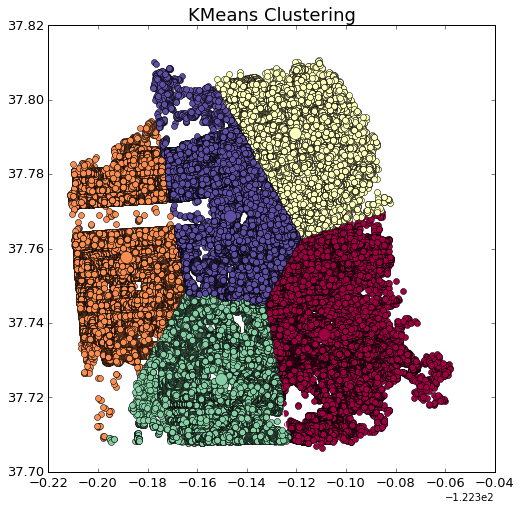

In [12]:
fig = plt.figure(figsize=(8, 8))
colors = plt.cm.Spectral(np.linspace(0, 1, n))

ax = fig.add_subplot(1, 1, 1)

for k, col in zip(range(n), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    plt.plot(data_plot[my_members, 1], data_plot[my_members, 0], 'w',
            markerfacecolor=col, marker='o', markersize=6)
    plt.plot(cluster_center[1], cluster_center[0], 'o',
            markerfacecolor=col, markeredgecolor='k', markersize=12)    
plt.title('KMeans Clustering',fontsize=18)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

In [14]:
size_all= []
for i in range (k_means_labels.max()):
    my_members = k_means_labels==i
    unique = find_unique(buildings_subset_df[my_members],'gid')
    size_all.append(unique)

In [28]:
k_means_labels.max()

4

In [24]:
size_all= []
for i in range (k_means_labels.max()+1):
    my_members = k_means_labels==i
    unique = buildings_subset_df[my_members]
    size_all.append(unique)

In [26]:
size_all[4]

,gid,fid_buildi,objname,numfaces,num_floor,fid_landus,blklot,block_num,lot_num,resunits,...,fid_tabblo,tractce10,housing10,lat,lon,num_people,pop10,lat_lat,lon_lon,num_people_int
310,311,59,SanfranX_1352,5,1,136639,976031,976,31,2,...,531972,13200,115,4523845.622,-13630392.70,0.302293,160,37.791590,-122.443969,0.0
311,312,60,SanfranX_1460,11,2,17978,0,975,0,1,...,533790,13200,64,4523860.385,-13630595.18,1.550441,139,37.791624,-122.445803,2.0
312,313,61,SanfranX_1575,189,6,18751,1024034,1024,34,2,...,531934,13400,147,4523406.911,-13630288.64,7.406069,237,37.788274,-122.443624,7.0
313,314,61,SanfranX_1575,189,6,19010,1024025,1024,25,0,...,531934,13400,147,4523402.968,-13630322.86,6.767084,237,37.788274,-122.443624,7.0
314,315,61,SanfranX_1575,189,6,19011,1024027,1024,27,10,...,531934,13400,147,4523398.025,-13630299.22,14.589722,237,37.788274,-122.443624,15.0
315,316,61,SanfranX_1575,189,6,19045,1024029,1024,29,2,...,531934,13400,147,4523410.405,-13630279.83,6.131301,237,37.788274,-122.443624,6.0
316,317,61,SanfranX_1575,189,6,19046,0,1024,0,3,...,531934,13400,147,4523411.658,-13630260.31,7.098768,237,37.788274,-122.443624,7.0
317,318,61,SanfranX_1575,189,6,153611,1024026,1024,26,16,...,531934,13400,147,4523396.041,-13630311.00,12.150609,237,37.788274,-122.443624,12.0
318,319,62,SanfranX_1608,5,1,17422,0,964,0,1,...,530161,13200,17,4523968.383,-13630553.32,0.116790,40,37.792461,-122.445391,0.0
319,320,63,SanfranX_1642,12,3,19175,1052026,1052,26,4,...,532855,15300,25,4522957.467,-13630081.46,2.266810,52,37.785181,-122.441185,2.0


In [21]:
size_all= []
hull_all =[]
patches =[]
all_geom = {}
colors = plt.cm.hot(np.linspace(0, 1, n))
colors=colors.tolist()
#colors = ['yellow', 'red', 'blue', 'green', 'violet']
for i in range (k_means_labels.max()+1):
    my_members = k_means_labels==i
    unique = find_unique(buildings_subset_df[my_members],'gid')
    size_all.append(unique)
    
    lat_lon = size_all[i][['lat_lat', 'lon_lon']]
    lat_lon_array = np.array(lat_lon)
    hull = ConvexHull(lat_lon_array)
    lat_lon_array = np.array(size_all[i][['lat_lat', 'lon_lon']])
    polygon_coords=[]
    for simplex in hull.vertices:
        x= lat_lon_array[simplex, 1]
        y = lat_lon_array[simplex, 0]
        coords = (x,y)
        polygon_coords.append(coords)
    polygon_coords_array = [polygon_coords]
    polygon = Polygon(polygon_coords_array)
    patches.append(polygon)


In [48]:
size_all_distance=[]
cluster_center_meters = [[] for i in range(k_means_labels.max())]
total_distance_schedule = 0
for i in range (k_means_labels.max()):
    for index, row in size_all[i].iterrows():
        meters = merc(row['lat_lat'], row['lon_lon'])
        cluster_center_meters[i].append(meters)
    if len(cluster_center_meters[i]) != 0:
        total_distance_truck = total_distance(optimized_travelling_salesman(cluster_center_meters[i]))/1000
        total_distance_schedule = total_distance_schedule + total_distance_truck

In [49]:
total_distance_schedule

1103.8212081500121

In [40]:
ice_map = folium.Map(location=[37.6236, -122.3750])
from random import randint
from matplotlib.colors import rgb2hex

i=0
for item in patches:
    with open('rest_%s.json' %i, 'w') as outfile: 
        json.dump(item, outfile)
    i=i+1
for z in range(i):
    color = matplotlib.colors.rgb2hex(colors[z])
    ice_map.geo_json(geo_path='rest_%s.json' %z, fill_color=color)
#ice_map.create_map(path='ice_map_test_2.html')
for item in k_means_cluster_centers:
    folium.RegularPolygonMarker(
    item,
    popup='Hawthorne Bridge',
    fill_color='#DC143C',
    number_of_sides=4,
    radius=7
    ).add_to(ice_map)
    
folium.RegularPolygonMarker(
cluster_center,
popup='Hawthorne Bridge',
fill_color='#00FFFF',
number_of_sides=6,
radius=10
).add_to(ice_map)

ice_map

C:\Users\Olga\Anaconda2\lib\site-packages\folium\folium.py:504: UserWarning: This method is deprecated. Please use Map.choropleth instead.
  warnings.warn('This method is deprecated. '


In [ ]:
cluster_center_meters = []
for item in k_means_cluster_centers:
    meters = merc(item[0], item[1])
    cluster_center_meters.append(meters)

In [ ]:
size_all_distance=[]
cluster_center_meters = [[] for i in range(k_means_labels.max())]
for i in range (k_means_labels.max()):
    for index, row in size_all[i].iterrows():
        meters = merc(row['lat_lat'], row['lon_lon'])
        cluster_center_meters[i].append(meters)
    total_distance_schedule = total_distance(optimized_travelling_salesman(cluster_center_meters[i]))
    total_peop = size_all[i]['num_people_int'].sum()
    totals = (i, total_peop, total_distance_schedule)
    size_all_distance.append(totals)

In [ ]:
totals_all_df = pd.DataFrame(size_all_distance, columns=['cluster', 'num_people', 'total_dist_m'])

In [ ]:
totals_all_df

In [ ]:
total_distance(optimized_travelling_salesman(cluster_center_meters))

In [ ]:
size_all_distance=[[] for i in range(k_means_labels.max())]
for i in range (k_means_labels.max()):
    for index, row in size_all[i].iterrows():
        harv=haversine(row['lat'],row['lon'], k_means_cluster_centers[i][0], k_means_cluster_centers[i][1])
        row['eu_dist'] = harv
        size_all_distance[i].append(row)

size_all_distance=[[] for i in range(k_means_labels.max())]
for i in range (k_means_labels.max()):
    for index, row in size_all[i].iterrows():
        point_lat_lon = [[row['lat'], row['lon']]]
        cluster_lat_lon = [[k_means_cluster_centers[i][0], k_means_cluster_centers[i][1]]]
        eu = cdist(point_lat_lon,cluster_lat_lon, 'euclidean')
        dist = eu[0][0]
        row['eu_dist'] = dist
        size_all_distance[i].append(row)

In [ ]:
n2 = 1
k_means_2 = KMeans(init='k-means++', n_clusters=n2)
k_means_2.fit(k_means_cluster_centers)

k_means_labels_2 = k_means_2.labels_
k_means_cluster_centers_2 = k_means_2.cluster_centers_
k_means_labels_unique_2 = np.unique(k_means_labels_2)
ft = (k_means_labels_2, k_means_cluster_centers_2)

fig = plt.figure(figsize=(8, 8))
colors = plt.cm.Spectral(np.linspace(0, 1, n2))

ax = fig.add_subplot(1, 1, 1)

for k, col in zip(range(n2), colors):
    my_members = k_means_labels_2 == k
    cluster_center = k_means_cluster_centers_2[k]
    plt.plot(k_means_cluster_centers[my_members, 1], k_means_cluster_centers[my_members, 0], 'w',
            markerfacecolor=col, marker='o', markersize=6)
    plt.plot(cluster_center[1], cluster_center[0], 'o',
            markerfacecolor=col, markeredgecolor='k', markersize=12)    
plt.title('KMeans Clustering',fontsize=18)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

In [ ]:
map_osm = folium.Map(location=[37.6236, -122.3750])
for item in k_means_cluster_centers:
    folium.RegularPolygonMarker(
    item,
    popup='Hawthorne Bridge',
    fill_color='#DC143C',
    number_of_sides=4,
    radius=7
    ).add_to(map_osm)
folium.RegularPolygonMarker(
cluster_center,
popup='Hawthorne Bridge',
fill_color='#00FFFF',
number_of_sides=6,
radius=10
).add_to(map_osm)

map_osm

In [ ]:
total_dist_all=[]
for i in range (k_means_labels.max()):
    df = pd.DataFrame(size_all_distance[i])
    total_dist = df['eu_dist'].sum()
    total_peop = df['num_people_int'].sum()
    all_totals = (i, total_peop, total_dist)
    total_dist_all.append(all_totals)

In [ ]:
totals_all_df = pd.DataFrame(total_dist_all, columns=['cluster', 'num_people', 'total_dist_m'])

In [ ]:
totals_all_df.to_csv('C:\Users\Olga\Documents\RENUWIT\Urine_separation\shapefiles\\totals_all_df_%d.csv' % n)

In [ ]:
cluster_center_meters = []
for item in k_means_cluster_centers:
    meters = merc(item[0], item[1])
    cluster_center_meters.append(meters)

In [ ]:
total_distance(optimized_travelling_salesman(cluster_center_meters))

In [1]:
import math
def merc(lat, lon):
    r_major = 6378137.000
    x = r_major * math.radians(lon)
    scale = x/lon
    y = 180.0/math.pi * math.log(math.tan(math.pi/4.0 + lat * (math.pi/180.0)/2.0)) * scale
    return (x, y)

In [11]:
a= 37.76348
b = -122.508049

point1 = (a,b)

c= 37.770735
d = -122.393043
point2 = (c,d)

In [8]:
from geopy.distance import vincenty

In [13]:
def distance_lat_lon(point1, point2):
    distance = vincenty(point1, point2).meters
    return distance

In [14]:
distance_lat_lon(point1, point2)

10165.065559269844